In [1]:
!git clone https://github.com/victorkitov/style-transfer-dataset/

Cloning into 'style-transfer-dataset'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (133/133), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 133 (delta 10), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (133/133), 40.57 MiB | 23.26 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [8]:
import torch
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

from style_transfer import stylize_image
from depth_aware_style_transfer import depth_aware_style_transfer, visualize_depth_layers
print('done')

done


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [4]:
# best content & style combos

df = pd.read_csv('style-transfer-dataset/user-ratings-all.csv')
df = df.sort_values(by='mean_rating', ascending=False)
df.head(n=20)

name  1_rating  2_rating  3_rating  \
2313  content_48___style_43___700.jpg        10        10        10   
2065   content_4___style_43___700.jpg        10        10        10   
4965    content_8___style_4___500.jpg        10        10        10   
4901   content_8___style_12___700.jpg        10        10        10   
5514   content_9___style_49___500.jpg        10        10        10   
5510   content_9___style_19___700.jpg        10        10        10   
4536  content_13___style_41___700.jpg        10        10        10   
3357  content_45___style_43___500.jpg        10        10        10   
929   content_26___style_19___300.jpg        10        10        10   
911   content_26___style_27___700.jpg        10        10        10   
921   content_26___style_14___500.jpg        10        10        10   
852   content_26___style_36___700.jpg        10        10        10   
1807  content_12___style_19___700.jpg        10        10        10   
4440  content_13___style_19___300.jpg        10        10        10   
1552  content_22___style_28___700.jpg        10        10        10   
4559  content_13___style_43___500.jpg        10        10        10   
4530  content_13___style_36___700.jpg        10        10        10   
948   content_26___style_19___500.jpg        10        10        10   
4532  content_13___style_43___700.jpg        10        10        10   
6230  content_29___style_45___300.jpg        10         9        10   

      mean_rating  
2313    10.000000  
2065    10.000000  
4965    10.000000  
4901    10.000000  
5514    10.000000  
5510    10.000000  
4536    10.000000  
3357    10.000000  
929     10.000000  
911     10.000000  
921     10.000000  
852     10.000000  
1807    10.000000  
4440    10.000000  
1552    10.000000  
4559    10.000000  
4530    10.000000  
948     10.000000  
4532    10.000000  
6230     9.666667

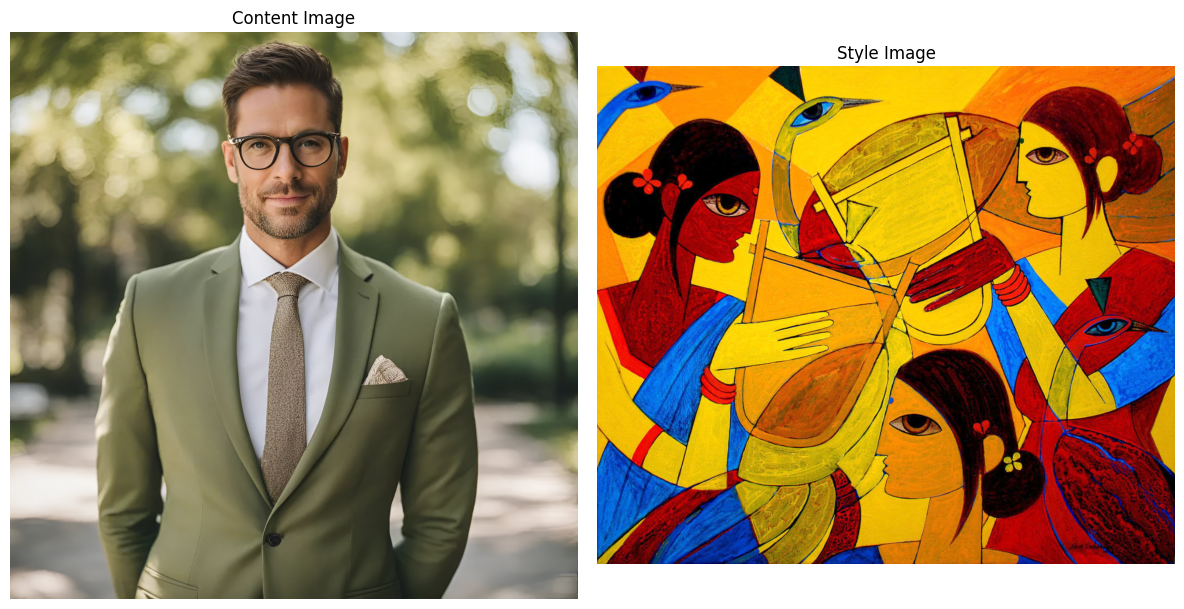

In [5]:
# load content & style
dataset_path = 'style-transfer-dataset'
content_path = os.path.join(dataset_path, 'contents', 'content_13.jpg')
style_path = os.path.join(dataset_path, 'styles', 'style_19.jpg')

content_img = Image.open(content_path)
style_img = Image.open(style_path)

# plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(content_img)
axes[0].set_title('Content Image')
axes[0].axis('off')
axes[1].imshow(style_img)
axes[1].set_title('Style Image')
axes[1].axis('off')
plt.tight_layout()
plt.show()

Content image shape: torch.Size([1, 3, 1080, 1080])
Style image shape: torch.Size([1, 3, 1080, 1080])
Device: cuda
Running style transfer for 300 steps...
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:06<00:00, 93.6MB/s]


Step 50: Content Loss: 0.9120, Style Loss: 0.6911
Step 100: Content Loss: 0.6690, Style Loss: 0.4628
Step 150: Content Loss: 0.7710, Style Loss: 0.5116
Step 200: Content Loss: 0.7255, Style Loss: 0.4714
Step 250: Content Loss: 1.0776, Style Loss: 0.8762
Step 300: Content Loss: 1.2848, Style Loss: 1.6213


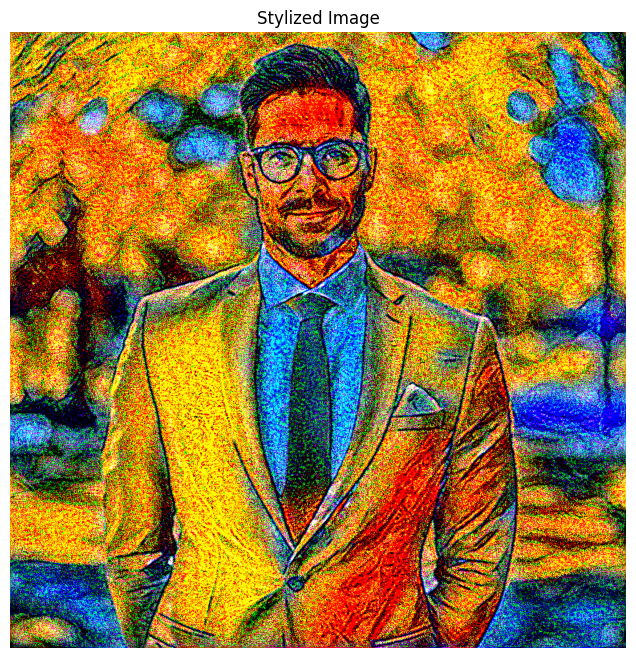

In [6]:
# baseline style transfer
stylized = stylize_image(
    content_path=content_path,
    style_path=style_path,
    output_size=1080,
    num_steps=300,
    style_weight=1e4,
    content_weight=1,
    verbose=True
)

# plot result
plt.figure(figsize=(10, 8))
plt.imshow(stylized)
plt.title('Stylized Image')
plt.axis('off')
plt.show()

Loading MiDaS depth estimation model...


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Content image size: (1080, 1080)
Estimating depth...
Computing depth masks...
Running style transfer (300 steps)...
Content image shape: torch.Size([1, 3, 1080, 1080])
Style image shape: torch.Size([1, 3, 1080, 1080])
Device: cuda
Running style transfer for 300 steps...
Step 50: Content Loss: 0.9224, Style Loss: 0.6784
Step 100: Content Loss: 0.7072, Style Loss: 0.4786
Step 150: Content Loss: 0.6457, Style Loss: 0.4453
Step 200: Content Loss: 0.9144, Style Loss: 0.6590
Step 250: Content Loss: 2.1445, Style Loss: 3.9994
Step 300: Content Loss: 0.9298, Style Loss: 0.6781
Blending layers...
Done!


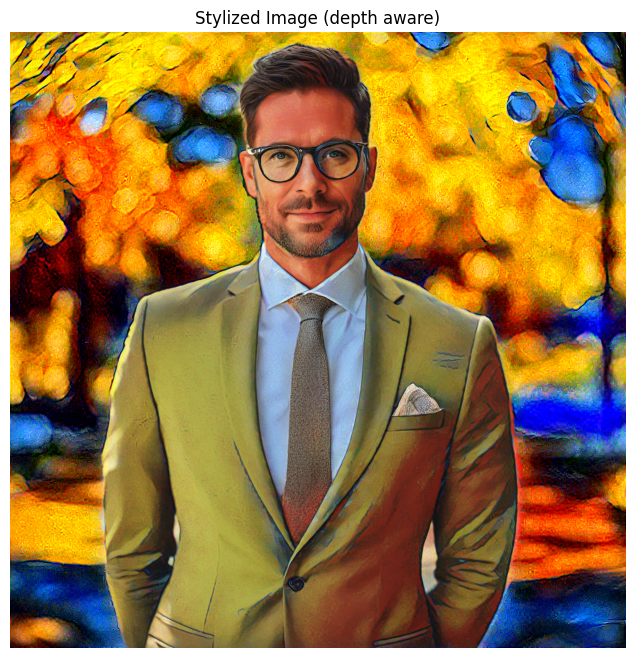

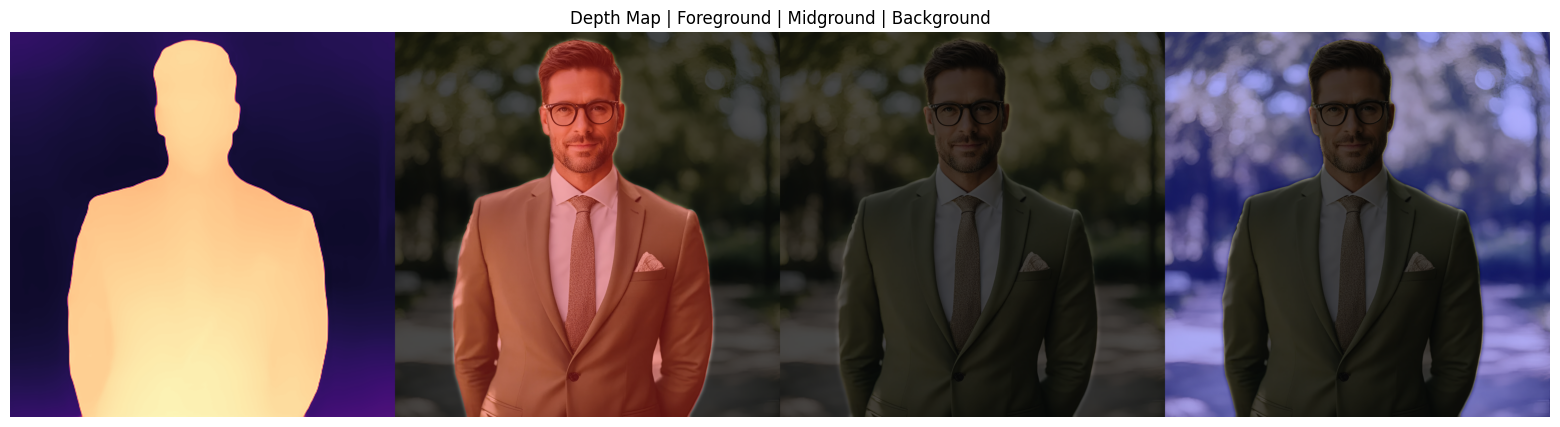

In [9]:
# depth aware style transfer
stylized_depth, depth_map, masks = depth_aware_style_transfer(
            content_path=content_path,
            style_path=style_path,
            output_size=1080,
            num_steps=300,
            style_weight=1e4,
            content_weight=1,
            fg_threshold=0.6,
            bg_threshold=0.3,
            style_strengths={
                'foreground': 0.3,
                'midground': 0.7,
                'background': 1.0
            },
            verbose=True
        )

# Convert PIL Image to numpy and resize to match output
content_np = np.array(content_img)
content_np = cv2.resize(content_np, (stylized_depth.shape[1], stylized_depth.shape[0]))

vis = visualize_depth_layers(content_np, depth_map, masks)

# plot result
plt.figure(figsize=(10, 8))
plt.imshow(stylized_depth)
plt.title('Stylized Image (depth aware)')
plt.axis('off')
plt.show()

# plot depth
plt.figure(figsize=(20, 5))
plt.imshow(vis)
plt.title('Depth Map | Foreground | Midground | Background')
plt.axis('off')
plt.show()